<b>Web Analytics DATA 620</b>

<b>Assignment: “Final Project”</b>

<b>Group - Chris Bloome / Mustafa Telab / Vinayak Kamath</b>

<b>Date - 16th July 2021</b>

--- 

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 


---

# Proposal



For our final project we will revisit a dataset from an earlier assignment, to apply the tools and concepts we have learned since.  The data is a collection of amazon reviews for fine foods.  We want to substitute the numerical rating for a more robust sentiment analysis of the review text; ultimately comparing how the structue of the network changes, controlling for the nature of the review.

The source of the data is snap.stanford.edu/data/web-Amazon.html; The csv file data includes:

- product/productId
- review/userId
- review/profileName
- review/helpfulness
- review/score
- review/time
- review/summary
- review/text

<b>Analysis Plan</b>
1. Read data into pandas dataframe.

2. Conduct sentiment analysis of the review texts to assign a classification and score.

3. Explore results, apply visualizations to understand the distribution of sentiment, and decide if the chosen classifications are useful or need to be redifined in step 2.

4. Build a projection network for each of the classifications; while integrating the sentiment scores into the edge attributes.

5. Compare centrality measures for each subgraph.  Define differences in network structure and identify important nodes for each.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import neo4j as neo
from sklearn import preprocessing
import numpy as np
import math
import re
from datetime import datetime
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
import os
#os.chdir('/Users/mustafatelab/Desktop/CUNY SPS MSDS/DATA 620 Web Analytics/SPS_MSDS_SMR21_DATA620')
os.chdir('C:\\Users\\Public\\kamathvk1981\\OneDrive\\Documents\\Vinayak\\CUNY\\Data620\\Final_Project')

For this exercise we are pulling product amazon.com product review data from 
https://snap.stanford.edu/data/web-Amazon.html

## Read Data


In [3]:
#Parsing instructions provided @https://snap.stanford.edu/data/web-Amazon.html
import gzip
import simplejson

def parse(filename):
  f = gzip.open(filename, 'rt', encoding = 'latin 1')
  entry = {}
  for l in f:
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

After parsing the raw data, we move to transform it into a pandas dataframe

In [4]:
raw = []
for e in parse('Data/finefoods.txt.gz'):
  raw.append(e)

In [5]:
df = pd.DataFrame(raw)

In [6]:
df = df[df['review/time'].notnull()].reset_index()


In [7]:
timestamp = list(df['review/time'].astype(int))

In [8]:
#Convert timestamp to datetime format
df['date'] = [datetime.utcfromtimestamp(v).strftime('%Y-%m-%d') for v in timestamp]
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [9]:
df = df.loc[df['date'] > pd.datetime(year = df['date'].max().year - 1 , month = 1, day = 1)].reset_index()

<ipython-input-9-06b5baa0fd82>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df = df.loc[df['date'] > pd.datetime(year = df['date'].max().year - 1 , month = 1, day = 1)].reset_index()


In [10]:
#sample data talen as first 100k records

df = df.iloc[:10000,:]

## Sentiment Analysis


In [11]:
print("Total Reviews")
print(len(df))
print("Distinct Products")
print(len(df['product/productId'].unique()))
print("Distinct Reviewers")
print(len(df['review/userId'].unique()))

Total Reviews
10000
Distinct Products
1844
Distinct Reviewers
9132


We see that there nearly every review is for a unique a product. If we had more reviews per prodcut, we might be able to do an analysis based on aggregate review and consistancy of word use. We still have plenety of options in this case, however. 

## (2) Conduct sentiment analysis of the review texts to assign a classification and score.

We have a field for Review/Summary and a second field for Review/Text, I beleive these are the bold part of the review you see on Amazon, and then the exposition below. We may as well concatenate these strings together for a larger sample per review.

In [12]:
df['review'] = df['review/summary'] + " " + df['review/text'] 

With a more robust review field, we will proceed by cleaning and tokenizing our review data. I borrowed a bit from [toward data science](https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e) to tokenize our reviews and flag with POS in a systematic way. 

In [13]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nshanbhag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nshanbhag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nshanbhag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

    
def clean(i):
    i = str(i).lower()
    i = [j.strip(string.punctuation) for j in i.split(" ")]
    i = [j for j in i if not any(c.isdigit() for c in j)]
    s = stopwords.words('english')
    i = [x for x in i if x not in s]
    i = [t for t in i if len(t) > 0]
    pos_tags = pos_tag(i)
    i = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    i = [t for t in i if len(t) > 1]
    i = " ".join(i)
    return(i)

# clean text data
df["review_clean"] = df["review"].apply(lambda x: clean(x))

Now we can use NLTK's VADER (Valence Aware Dictionary for Sentiment Reasoning) to assign Sentiment values

In [15]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nshanbhag\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [17]:
# I beleive this is a very "R" way of doing this. It works in Python but shows a warning. 
# Following code supresses warning 
import warnings
warnings.filterwarnings('ignore')

df['negative'] = ""
df['neutral'] = ""
df['positive'] = ""
df['compound'] = ""

for i in range(len(df)):
    sentiment = sia.polarity_scores(df['review_clean'][i])
    df['negative'][i] = sentiment['neg']
    df['neutral'][i] = sentiment['neu']
    df['positive'][i] = sentiment['pos']
    df['compound'][i] = sentiment['compound']


Vader provides a percent probability for Positive, Negative and Neutral values, such that the sum is 100%. It also provides a Compound score ranging from -1 to 1. I included the Positive/Negative/Neutral scores, however, we will focus on the compound score. Anything over 50% will be flagged as positive, with anything under 50% as negative. The middle range we will flag as neutral or unknown.

In [18]:
conditions = [
    (df['compound'] >= .5),
    (df['compound'] <= -.5),
    (df['compound'] < .5) & (df['compound'] > -.5)]

values = ['Positive', 'Negative', 'Neutral/Unknown']

df['Sentiment'] = np.select(conditions, values)

In [19]:
df.head()

level_0  index product/productId   review/userId  \
0        0      0        B001E4KFG0  A3SGXH7AUHU8GW   
1        1      1        B00813GRG4  A1D87F6ZCVE5NK   
2        3      3        B000UA0QIQ  A395BORC6FGVXV   
3        4      4        B006K2ZZ7K  A1UQRSCLF8GW1T   
4        5      5        B006K2ZZ7K   ADT0SRK1MGOEU   

              review/profileName review/helpfulness review/score review/time  \
0                     delmartian                1/1          5.0  1303862400   
1                         dll pa                0/0          1.0  1346976000   
2                           Karl                3/3          2.0  1307923200   
3  Michael D. Bigham "M. Wassir"                0/0          5.0  1350777600   
4                 Twoapennything                0/0          4.0  1342051200   

          review/summary                                        review/text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2         Cough Medicine  If you are looking for the secret ingredient i...   
3            Great taffy  Great taffy at a great price.  There was a wid...   
4             Nice Taffy  I got a wild hair for taffy and ordered this f...   

        date                                             review  \
0 2011-04-27  Good Quality Dog Food I have bought several of...   
1 2012-09-07  Not as Advertised Product arrived labeled as J...   
2 2011-06-13  Cough Medicine If you are looking for the secr...   
3 2012-10-21  Great taffy Great taffy at a great price.  The...   
4 2012-07-12  Nice Taffy I got a wild hair for taffy and ord...   

                                        review_clean negative neutral  \
0  good quality dog food buy several vitality can...      0.0   0.533   
1  advertised product arrive labeled jumbo salt p...    0.123   0.773   
2  cough medicine look secret ingredient robituss...      0.0   0.868   
3  great taffy great taffy great price wide assor...      0.0   0.339   
4  nice taffy get wild hair taffy order five poun...    0.042   0.624   

  positive compound        Sentiment  
0    0.467   0.9382         Positive  
1    0.105  -0.1027  Neutral/Unknown  
2    0.132   0.4404  Neutral/Unknown  
3    0.661   0.9661         Positive  
4    0.335   0.9382         Positive

In [20]:
#convert to numeric for calculations
#cols= ['Rating_Sentiment','review/score']
cols= ['review/score','compound']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Simialrly, we will treat any review with exactly 3 stars (as given by the user) as Neutral. Anything over as Positive and under as negative. 

In [21]:
conditions = [
    (df['review/score']) > 3,
    (df['review/score']) < 3,
    (df['review/score']) ==  3]

values = ['Positive', 'Negative', 'Neutral/Unknown']

df['Rating_Sentiment'] = np.select(conditions, values)

In [22]:
print(df.groupby('Rating_Sentiment')['product/productId'].count())
print("")
print(df.groupby(['Sentiment','Rating_Sentiment'])['product/productId'].count())

Rating_Sentiment
Negative           1574
Neutral/Unknown     798
Positive           7628
Name: product/productId, dtype: int64

Sentiment        Rating_Sentiment
Negative         Negative             294
                 Neutral/Unknown       28
                 Positive              58
Neutral/Unknown  Negative             518
                 Neutral/Unknown      157
                 Positive             402
Positive         Negative             762
                 Neutral/Unknown      613
                 Positive            7168
Name: product/productId, dtype: int64


## (3) Explore results, apply visualizations to understand the distribution of sentiment, and decide if the chosen classifications are useful or need to be redifined in step 2.

We see that most of our reviews are positive. That being said, Vader seems to be great at selecting which reviews are positive. Due to the overwhelming number of positive reviews, lets restructure this data such that we are interesting in flagging reviews as "positive" or "other" and structure our analysis this way. 

In [23]:
df['Positive_Sentiment'] = df['compound']>.5
df['Positive_Review'] = df['review/score']>3

In [24]:
print(df.groupby(['Positive_Review','Positive_Sentiment'])['product/productId'].count())

Positive_Review  Positive_Sentiment
False            False                  998
                 True                  1374
True             False                  460
                 True                  7168
Name: product/productId, dtype: int64


Not bad! Lets calculate sensitivity and specificity. We will assume our model is trying to predict reviews which were rated positively by the review.

In [25]:
conditions = [
    (df['Positive_Sentiment'] == True) & (df['Positive_Review'] == True),
    (df['Positive_Sentiment'] == True) & (df['Positive_Review'] == False),
    (df['Positive_Sentiment'] == False) & (df['Positive_Review'] == True),
    (df['Positive_Sentiment'] == False) & (df['Positive_Review'] == False)]

values = ['TP', 'FP', 'FN', 'TN']

df['Category'] = np.select(conditions, values)

In [26]:
TP = len(df[df['Category']=="TP"])
FP = len(df[df['Category']=="FP"])
TN = len(df[df['Category']=="TN"])
FN = len(df[df['Category']=="FN"])


In [27]:
print("Sensitivity, percentage of reviews rated positive by the user that sentiment anaysis labled as positive:")
print(TP/(TP+FN))
print("")
print("Specificity, percentage of reviews rated negative (under 4 stars) by the user that sentiment anaysis labled as negative:")
print(TN/(TN+FP))
print("")
print("Percision, percentage of reviews rated positive by sentiment anaysis that the user rated as positive")
print(TP/(TP+FP))

Sensitivity, percentage of reviews rated positive by the user that sentiment anaysis labled as positive:
0.9396958573675931

Specificity, percentage of reviews rated negative (under 4 stars) by the user that sentiment anaysis labled as negative:
0.42074198988195616

Percision, percentage of reviews rated positive by sentiment anaysis that the user rated as positive
0.8391477405759775


One additional analysis I am interested in is review length. I suspect that short positive reviews may not contain enough positive words to be labeled as such by our model.

In [28]:
# Assuming there is exactly one space between each word, which we know that there is per our cleaning of the data. 
df['review length'] =df['review_clean'].str.count(' ') + 1

In [29]:
df.groupby(['Category'])['review length'].mean()

Category
FN    31.069565
FP    54.402475
TN    36.383768
TP    40.704660
Name: review length, dtype: float64

In [30]:
df.groupby(['Category'])['review length'].median()

Category
FN    23.0
FP    42.0
TN    27.5
TP    29.0
Name: review length, dtype: float64

**Review to make sure this holds true as sample changes** 

Interestingly enough, False Positives have the largest word count. It seems as though as reviews get longer, sentiment analysis becomes less accurate.  

# 3.b Visuals / Analysis

## Language

**20 Most Common Words in Dataset** 

In [31]:
# Join questions into long string 
word_list = ' '.join(df['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])


['like',
 'good',
 'taste',
 'great',
 'coffee',
 'love',
 'flavor',
 'product',
 'make',
 'one',
 'use',
 'get',
 'try',
 'buy',
 'dog',
 'find',
 'food',
 'would',
 'treat',
 'well']

**20 Most Common Words in True Positive Reviews** 

In [32]:
# Join questions into long string 
word_list = ' '.join(df[df['Category']=='TP']['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])


['good',
 'great',
 'like',
 'love',
 'taste',
 'coffee',
 'flavor',
 'make',
 'one',
 'product',
 'use',
 'get',
 'try',
 'dog',
 'best',
 'find',
 'buy',
 'food',
 'treat',
 'well']

**20 Most Common Words in True Negative Reviews** 

In [33]:
# Join questions into long string 
word_list = ' '.join(df[df['Category']=='TN']['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])

['taste',
 'product',
 'coffee',
 'like',
 'flavor',
 'buy',
 'get',
 'one',
 'make',
 'would',
 'bad',
 'use',
 'try',
 'order',
 'good',
 'cup',
 'dog',
 'say',
 'box',
 'food']

**20 Most Common Words in False Negative or False Positive Reviews** 

In [34]:
# Join questions into long string 
word_list = ' '.join(df[((df['Category']=='FN') | (df['Category']=='FP'))]['review_clean'])

# Split string into individual words
word_list = word_list.split()

# Generate Dict with word count
word_list_ct = pd.Series(word_list).value_counts().to_dict()

# Convert Dict to DF
word_list_df = pd.DataFrame(list(word_list_ct.items()),columns = ['word','count']) 

word_list_df = word_list_df[word_list_df.word != "br"]

list(word_list_df[0:20]['word'])

['like',
 'taste',
 'good',
 'coffee',
 'product',
 'flavor',
 'make',
 'one',
 'buy',
 'get',
 'use',
 'would',
 'try',
 'dog',
 'great',
 'find',
 'food',
 'love',
 'well',
 'much']

### Word Cloud 
Let's generate a word cloud for each of our categories:

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# dataset.drop(['labels'], axis = 1, inplace = True)

### True Positives

Reviews our model correctly identified as positive.

In [36]:
def wordgather(df, cat):
    words = ' '.join((df[df['Category']==cat]['review_clean']))
    words = words.split()
    words = [x for x in words if x != 'br']
    words = [x for x in words if "b r" not in x]
    words =  ' '.join(words)
    words_wc = WordCloud(height = 600, width = 600).generate(words)
    return words_wc

In [37]:
wc_TP = wordgather(df, 'TP')
wc_TN = wordgather(df, 'TN')
wc_FP = wordgather(df, 'FP')
wc_FN = wordgather(df, 'FN')

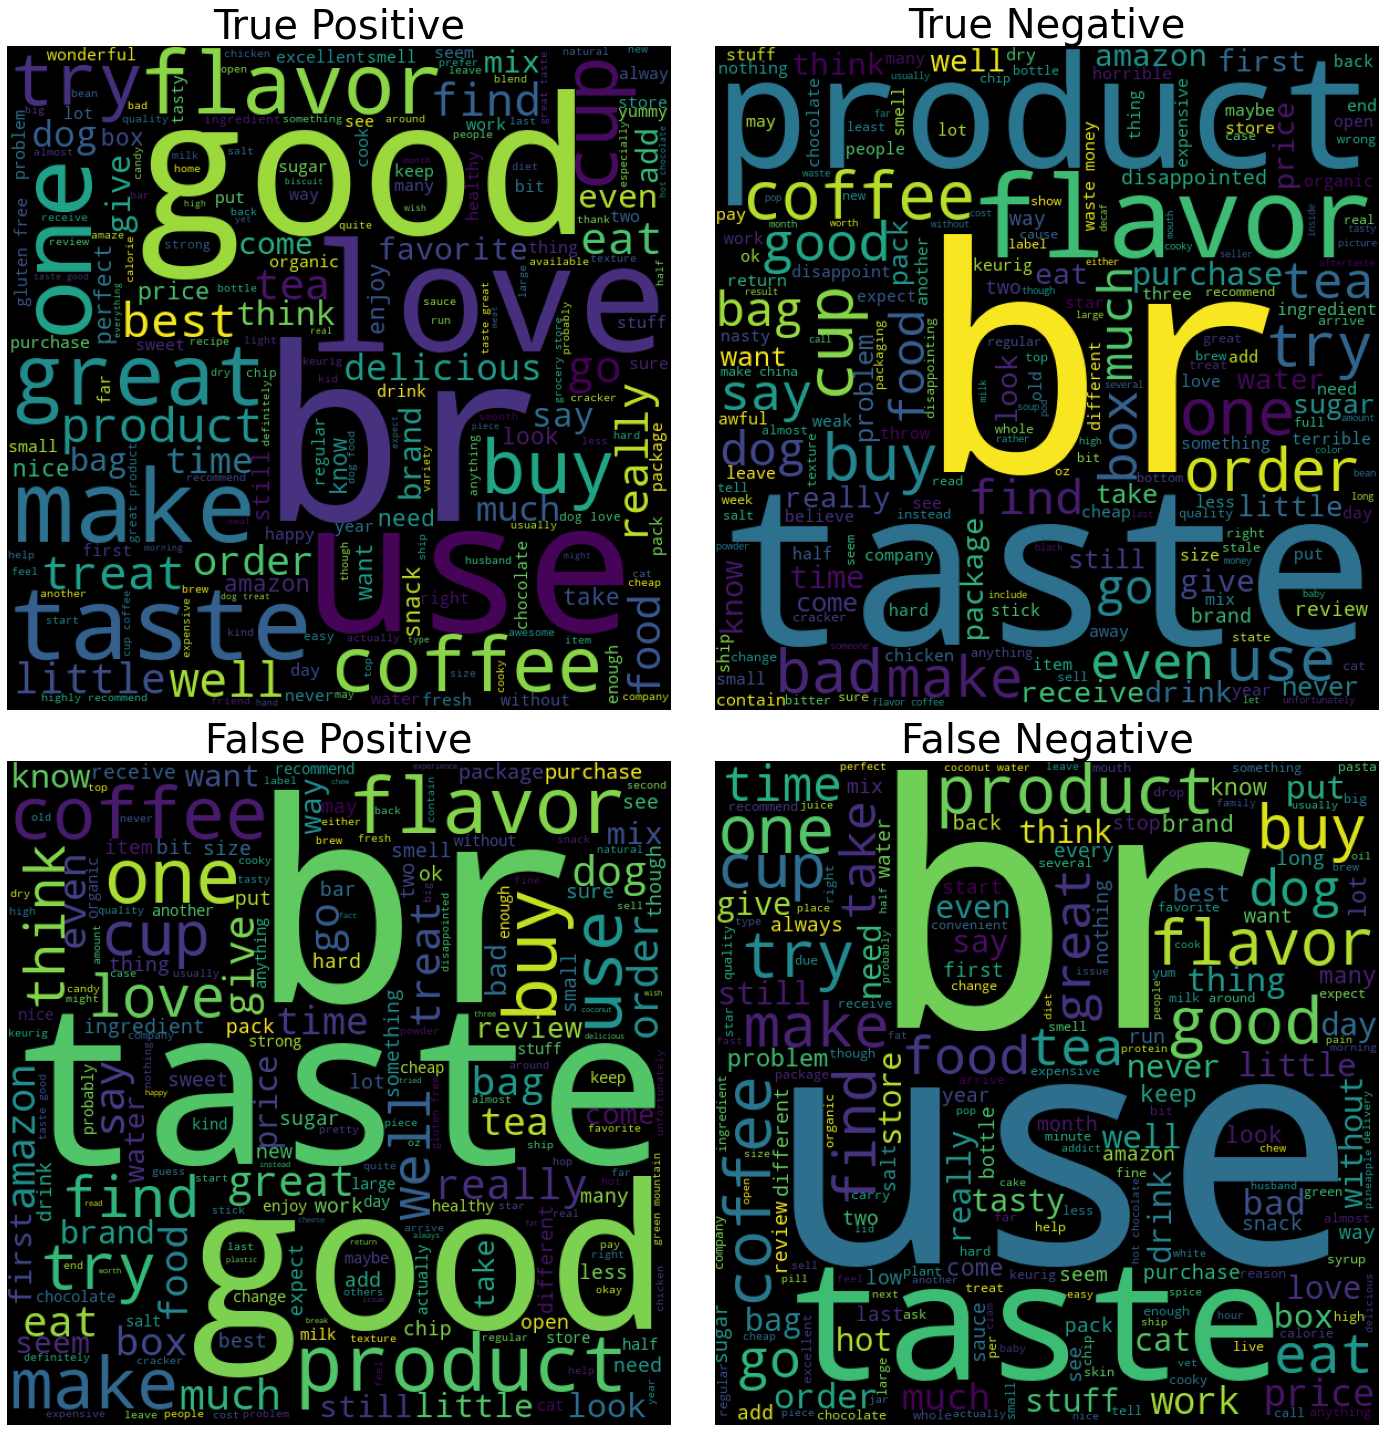

In [38]:
fig, axs = plt.subplots(2,2, figsize = (20, 20))
axs[0,0].imshow(wc_TP)
axs[0,0].axis('off')
axs[0,0].set_title('True Positive', fontsize = 40)
axs[0,1].imshow(wc_TN)
axs[0,1].axis('off')
axs[0,1].set_title('True Negative', fontsize = 40)
axs[1,0].imshow(wc_FP)
axs[1,0].axis('off')
axs[1,0].set_title('False Positive', fontsize = 40)
axs[1,1].imshow(wc_FN)
axs[1,1].axis('off')
axs[1,1].set_title('False Negative', fontsize = 40)
fig.tight_layout()
fig.show()

## Metric Visualizations

In [39]:
#Calculate Confusion Matrix
cf_matrix = confusion_matrix(df['Positive_Review'], df['Positive_Sentiment'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

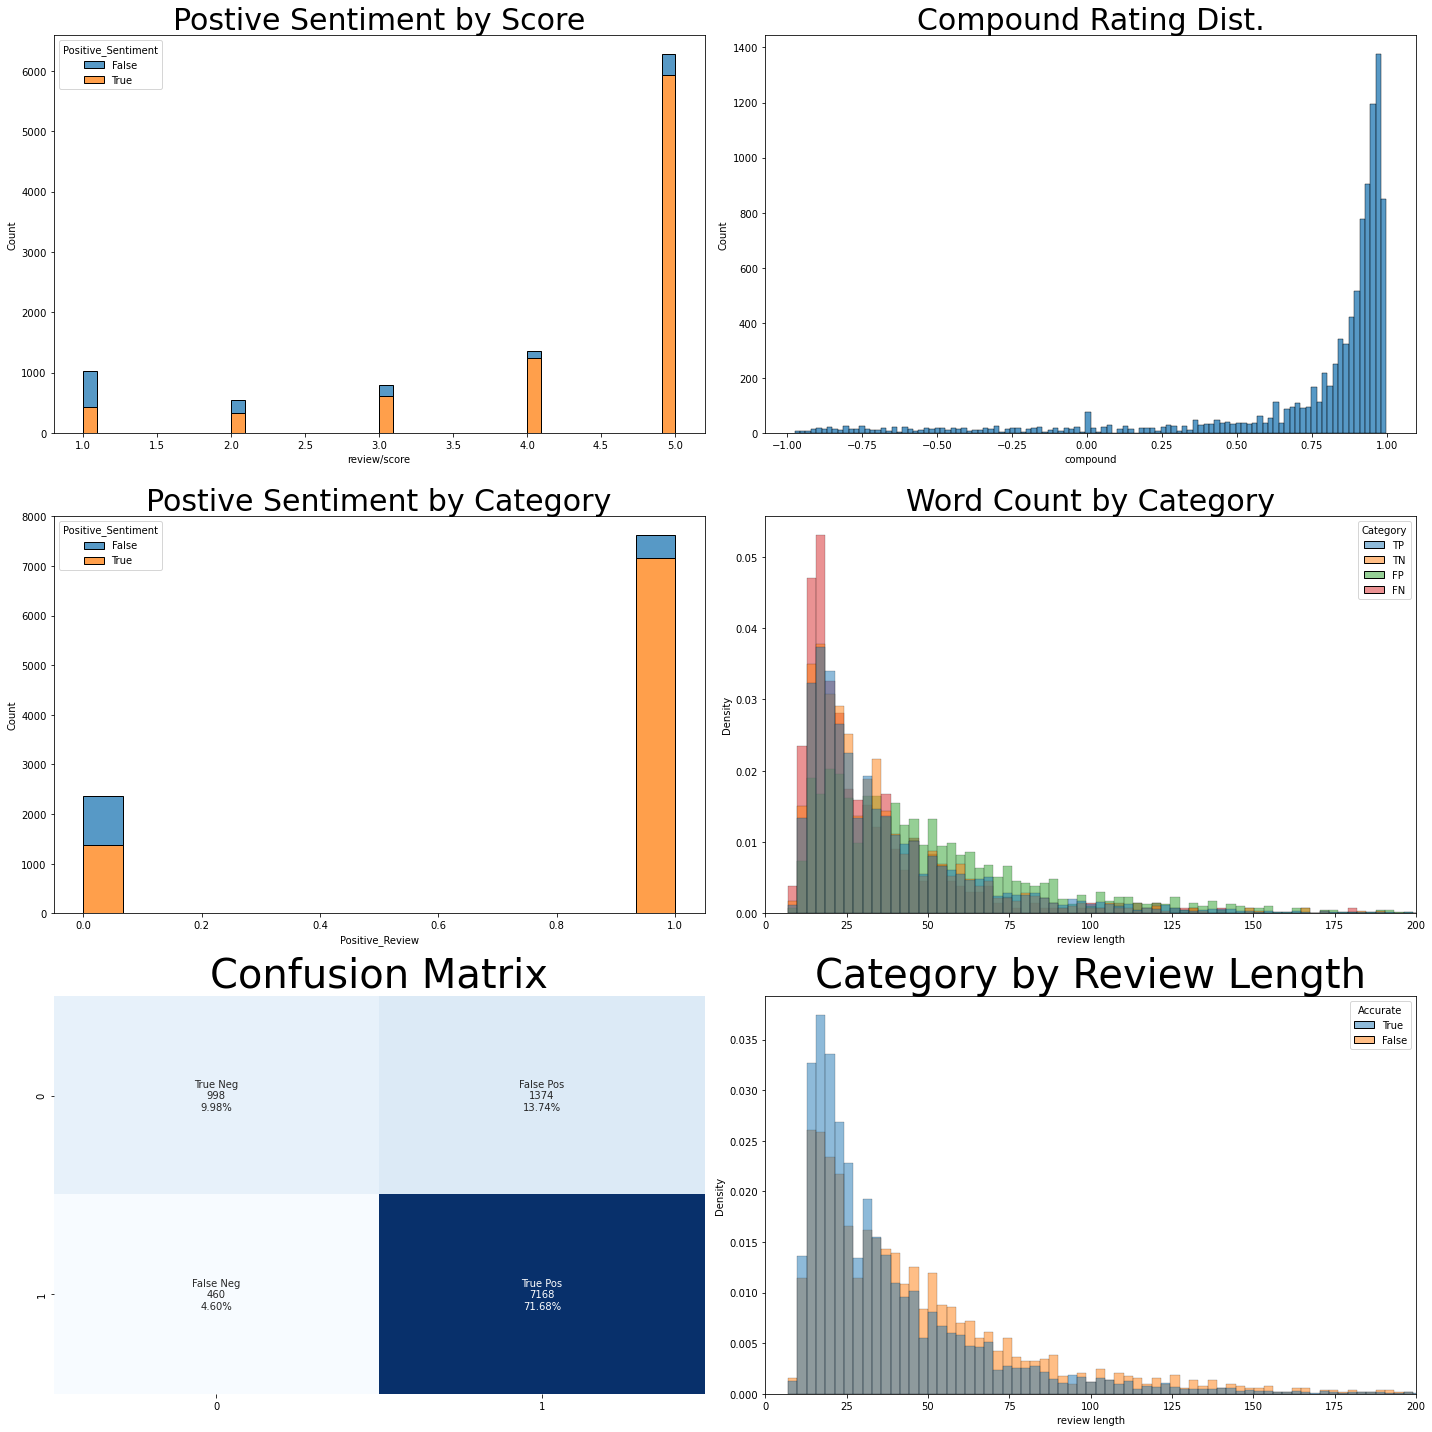

In [40]:
fig, axs = plt.subplots(3,2, figsize = (20, 20))
sns.histplot(data=df, x="compound", ax=axs[0,1])
axs[0,1].set_title('Compound Rating Dist.', fontsize = 30)
sns.histplot(data=df, x="review/score", hue='Positive_Sentiment', multiple="stack", ax=axs[0,0])
axs[0,0].set_title('Postive Sentiment by Score', fontsize = 30)
sns.histplot(data=df, x="Positive_Review", hue='Positive_Sentiment', multiple="stack", ax=axs[1,0])
axs[1,0].set_title('Postive Sentiment by Category', fontsize = 30)
sns.histplot(data=df, x="review length", hue='Category', stat='density',  common_norm=False, ax=axs[1,1]).set(xlim=(0, 200))
axs[1,1].set_title('Word Count by Category', fontsize = 30)

conditions = [
    (df['Category'] == "TP") | (df['Category'] == "TN"),
     (df['Category'] == "FP") | (df['Category'] == "FN")]
values = ["True", "False"]
df['Accurate'] = np.select(conditions, values)
sns.histplot(data=df, x="review length", hue='Accurate', stat='density',  common_norm=False, ax=axs[2,1]).set(xlim=(0, 200))
axs[2,1].set_title('Category by Review Length', fontsize = 40)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, ax=axs[2,0])
axs[2,0].set_title('Confusion Matrix', fontsize = 40)
fig.tight_layout()
fig.show()

## Build Network

Sentiment Analysis is complete.  Now we turn to the network portion of the analysis.  We will examine the structure of the nodes to decide what insights can be drawn.

<BR>Firstly, we establish graph 'G'; integrating the results from the above sentiment analysis.  This will serve as the start of our network analysis.  The only filter applied to this point is removing those records where the review field was Null.

Edge Attributes
<br>'negative'
<br>'neutral'
<br>'positive'
<br>'compound'
<br>'review length'
<br>'Sentiment'
<br>'Category'


Node attributes;
<br>'Average Sentiment' - Aggregation of word analysis
<br>'Average Score' - Aggregation of user reviews
<br>'Type' - User vs Product to facilitate projection graph

In [41]:
#Convert Pandas dataframe into a graph; assign relevant fields as edge attributes
G = nx.from_pandas_edgelist(df, source = 'review/userId',target = 'product/productId', edge_attr = ['negative', 'neutral', 'positive', 'compound','Sentiment','Category','review length'])

In [42]:
#Calculate node metrics and assign node type to be used later in projections.
df_avg_from_user = df.groupby(['review/userId']).aggregate({('compound'):np.average, ('review/score'):np.average}).rename(columns={'compound':'Average Sentiment','review/score':'Average Score'})
df_avg_from_user['type'] = 'User'
df_avg_for_product = df.groupby(['product/productId']).aggregate({('compound'):np.average, ('review/score'):np.average}).rename(columns={'compound':'Average Sentiment','review/score':'Average Score'})
df_avg_for_product['type'] = 'Product'

In [43]:
#Create dict of dicts to populate the networks node attributes
node_attr = df_avg_from_user.to_dict().update(df_avg_for_product.to_dict())

In [44]:
#Add Node Attributes
nx.set_node_attributes(G, df_avg_from_user.to_dict('index'))

In [45]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10976
Number of edges: 9924
Average degree:   1.8083


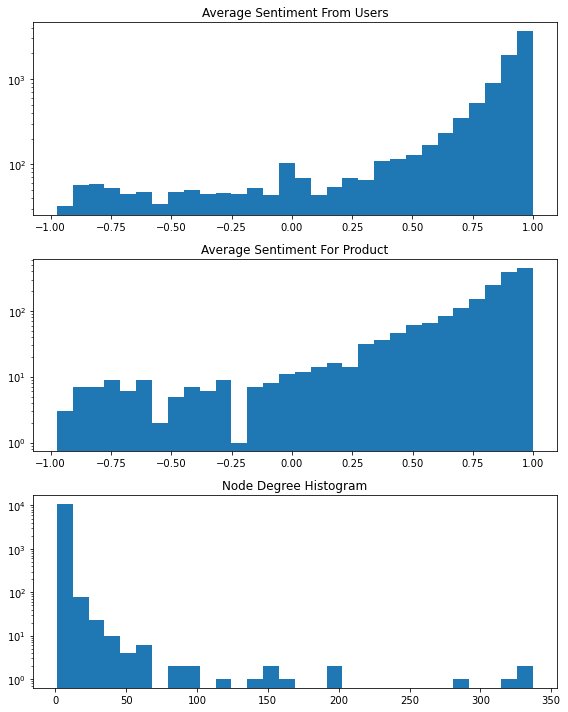

In [46]:
fig, axs = plt.subplots(3,figsize=(8, 10))

axs[0].hist(df_avg_from_user['Average Sentiment'], bins = 30)
axs[0].set_yscale("log")
axs[0].set_title('Average Sentiment From Users')


axs[1].hist(df_avg_for_product['Average Sentiment'], bins = 30)
axs[1].set_yscale("log")
axs[1].set_title('Average Sentiment For Product')

axs[2].hist(dict(G.degree()).values(), bins = 30)
axs[2].set_yscale("log")
axs[2].set_title('Node Degree Histogram')

fig.tight_layout()
fig.show()

## Graphs


It is obvious that the sentiment and raw review score skew heavily to the positive.  Thus, it may not be relevant to partition the network by simply Positive vs Negative classifcation.
<BR>We will proceed with the goal of delivering two networks.  Both will be filtered using an "Island Method."  However, the first('users_top') will be a prjection of the users on the high end of average sentiment score, while the second('users_bottom') stem from the other end.  

In [47]:
user_stats = df_avg_from_user['Average Sentiment'].describe()
users_top = df_avg_from_user['Average Sentiment'][df_avg_from_user['Average Sentiment']>user_stats['75%']].index.to_list()
users_bottom = df_avg_from_user['Average Sentiment'][df_avg_from_user['Average Sentiment']<user_stats['25%']].index.to_list()

In [48]:
def trim_nodes(g, degrees=1):
    nodes = []
    for n in g.nodes():
        if g.degree(n) > degrees:
            nodes.append(n)
    G2 = g.subgraph(nodes)
    return G2

In [49]:
#modifiction of code clock found on Social Network Analysis for Startups, pg64 
def trim_edges(g, attribute,  weight=.5):
    l = []
    g2 = g.copy(as_view=False)
    for f, to, edata in g.edges(data=True):
            if (edata[attribute] < weight):
                l.append((f,to))
    v = []            
    for x in l:
            if x not in v:
                v.append(x)
    g2.remove_edges_from(v)
    g3 = nx.subgraph(g2, list(nx.connected_components(g2))[0])
    return g3

In [50]:
#modifiction of code clock found on Social Network Analysis for Startups, pg44
def snowball_sampling(g, center,node_limit, max_depth=1, current_depth=0, taboo_list=[]):
    #print(center, current_depth, max_depth, taboo_list)
    if (current_depth==max_depth) or (len(taboo_list)>node_limit):
        #if we have reached the depth limit of the search, return.
        #print('out of depth')
        return taboo_list
    if center in taboo_list:
        #we've been here before -- return right away
        return taboo_list
    else:
        taboo_list.append(center) # we shall never return to the same node
    for node in g.neighbors(center):
        # Iterate through all friends of the central node, call snowball_sampling recursively
        taboo_list=snowball_sampling(g, node, node_limit,current_depth=current_depth+1,max_depth=max_depth, taboo_list=taboo_list)
    return taboo_list

In [51]:
def graph_template(g, nodes):
    sub_g = nx.subgraph(g,nodes)
    pos = nx.kamada_kawai_layout(sub_g)
    line_w = np.array(nx.get_edge_attributes(sub_g, 'compound').values())
    line_col = np.array(nx.get_edge_attributes(sub_g, 'Sentiment').values())
    node_size = np.array(list(dict(sub_g.degree()).values()))
    node_col = np.array(list(nx.get_node_attributes(sub_g,'Average Sentiment').values()))
    #node_labs = nx.get_node_attributes(sub_g, 'Average Sentiment')

    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(
            sub_g,
            pos = pos, 
            alpha =.7, 
            width = .1, 
            arrows=False ,
            #edge_color= line_col,
            #edge_cmap = plt.cm.spring, 
            #node_size = node_size , 
            #node_color= node_col, 
            #cmap =plt.cm.winter 
           )
    #ax.margins(-.20, -.20)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

In [52]:
U_top = nx.bipartite.overlap_weighted_projected_graph(G,users_top)
U_bottom = nx.bipartite.overlap_weighted_projected_graph(G,users_bottom)

In [53]:
U_top_trim = trim_nodes(U_top, degrees=10)
U_bottom_trim = trim_nodes(U_bottom, degrees=10)

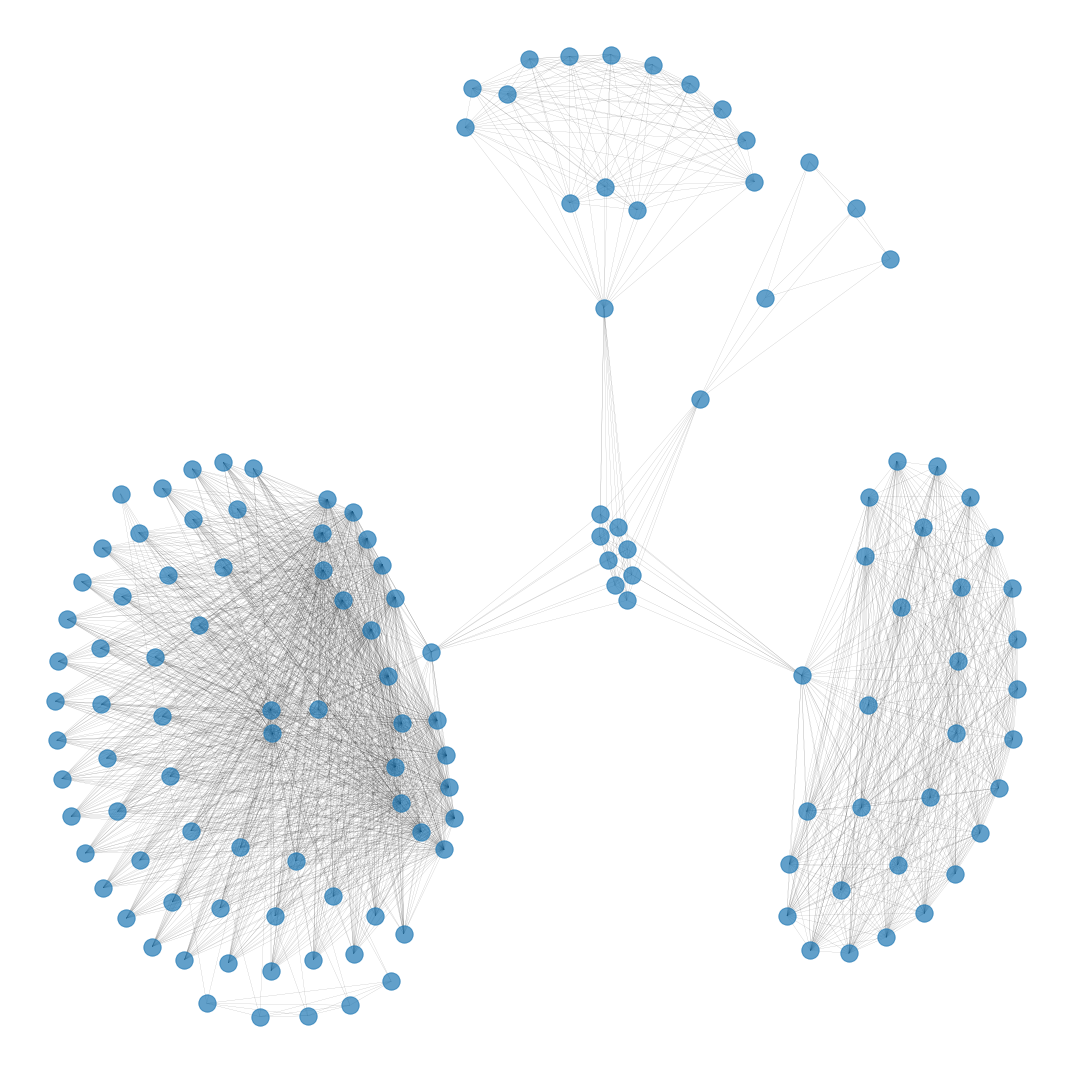

In [54]:
graph = U_top_trim
centralnode = random.sample(graph.nodes(),1)[0]
nodes = snowball_sampling(graph, centralnode, node_limit = 300, max_depth=10, current_depth=0, taboo_list=[])
graph_template(graph, nodes)



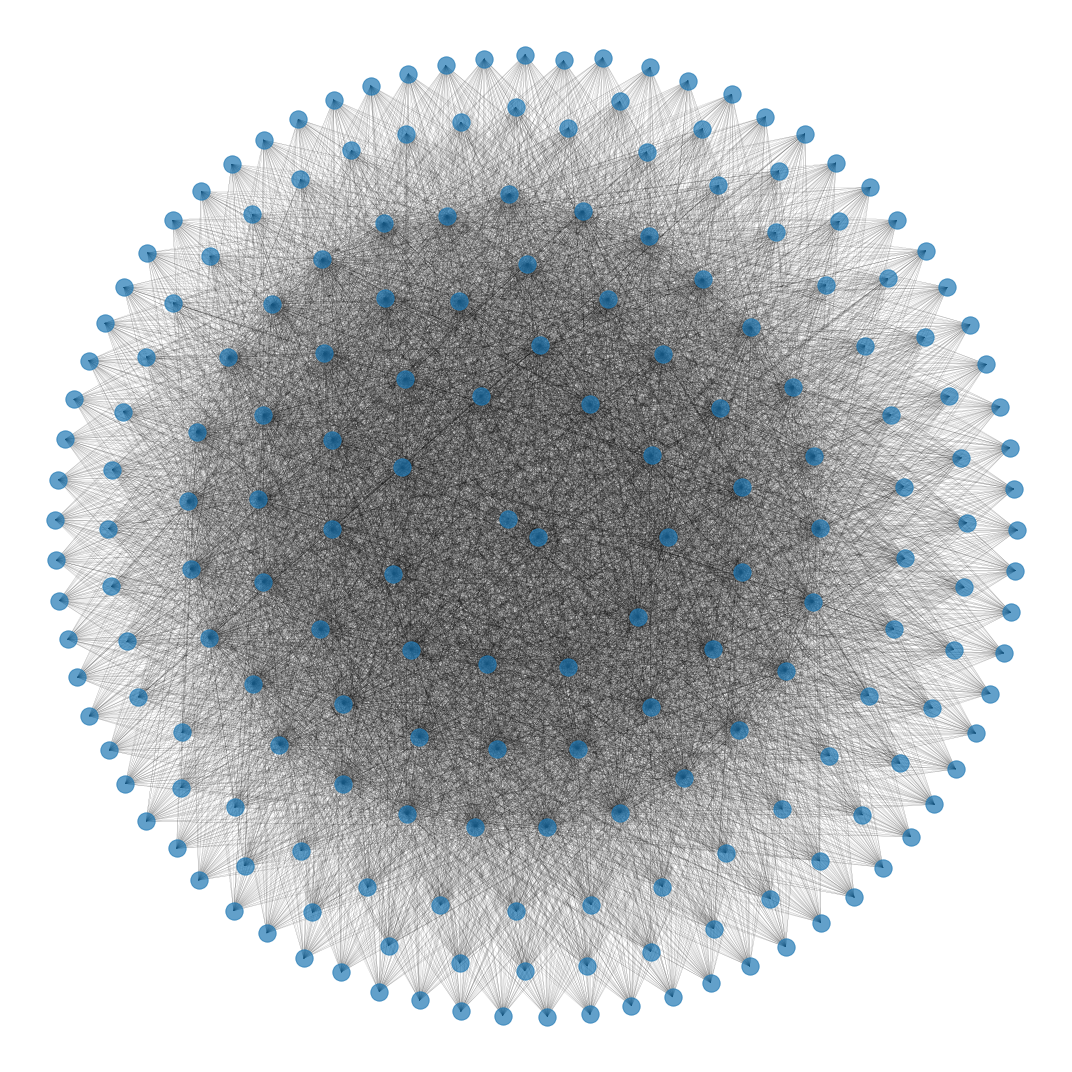

In [55]:
graph = U_bottom_trim
centralnode = random.sample(graph.nodes(),1)[0]
nodes = snowball_sampling(graph, centralnode, node_limit = 300, max_depth=10, current_depth=0, taboo_list=[])
graph_template(graph, nodes)



## Comparison


In [56]:
from tabulate import tabulate

from itertools import count

from pyvis.network import Network

In [57]:
# We will create a function that will take the Graph Object as input and calcualte the 
# centrality metrics and display as output

def get_centrality(G_search):
    
    d=nx.degree_centrality(G_search)
    dc_sorted_tuples = sorted(d.items(), key=lambda item: item[1], reverse=True)
    dc_sorted_dict = {k: v for k, v in dc_sorted_tuples}
    
    # e=nx.eigenvector_centrality(G_search, weight='trips')
    # ec_sorted_tuples = sorted(e.items(), key=lambda item: item[1], reverse=True)
    # ec_sorted_dict = {k: v for k, v in ec_sorted_tuples}
    
    b=nx.betweenness_centrality(G_search , weight='trips')
    bc_sorted_tuples = sorted(b.items(), key=lambda item: item[1], reverse=True)
    bc_sorted_dict = {k: v for k, v in bc_sorted_tuples}
    
    c=nx.closeness_centrality(G_search )
    cc_sorted_tuples = sorted(c.items(), key=lambda item: item[1], reverse=True)
    cc_sorted_dict = {k: v for k, v in cc_sorted_tuples}

    ## We will now make a list of the stations for 4 centrality metrics 

    names1= {}
    # names2= {}
    names3= {}
    names4= {}

    for key, value in dc_sorted_dict.items():
        names1[key]= value

    # for key, value in ec_sorted_dict.items():
    #     names2[key]= value

    for key, value in bc_sorted_dict.items():
        names3[key]= value

    for key, value in cc_sorted_dict.items():
        names4[key]= value

    ## use Python sets to compute a union of the sets 
    #names=list(set(names1) | set(names2)| set(names3)| set(names4)  )
    ## use the networksx vorterrank function to get a sorted list of nodes based on its influence ranking:
    names =nx.voterank(G_search)

    ## build a table with centralities 
    table=[[name,d[name], b[name],c[name] ] for name in names[:10]]

    print (tabulate(table, headers= ["Node", "Degree", "Betweeness", "Closeness"]))

In [58]:
# taken from https://towardsdatascience.com/networkx-code-demo-for-manipulating-subgraphs-e45320581d13
# Study a certain node in the graph

def drawnodegraph(graph, nodename, info=False,weightbar=0):
  # graph will be your networkx graph
  # nodename will be the node that you want to focus on
  # the default value for weightbar is 0, if increase the bar, rare relationship will be removed. Assuming no negative weights
  temp = graph.copy(as_view=False) # make a temporary graph to avoid losing original ones
  temp.remove_edges_from((e for e, w in nx.get_edge_attributes(temp,'weight').items() if w <= weightbar)) # remove rare relationhsip if weightbar is not 0
  nodelist = list(temp.neighbors(n=nodename)) #generate the nodes that have relationship with our target node
  nodelist.append(nodename) # add the target to the list
  Sub = temp.subgraph(nodelist) # draw subgraph
  edges,weights = zip(*nx.get_edge_attributes(Sub,'weight').items())
  pos=nx.spring_layout(Sub,k=0.7,seed=42)
  node_map = {nodename:7000} 
  nodesize=[node_map.get(node, 3500) for node in Sub.nodes()] # enlarge our target node
  val_map = {nodename:0.5714285714285714}
  nodecolor = [val_map.get(node, 0.25) for node in Sub.nodes()] # change the color of our target node
  width = [w*5 for w in weights] # change the edge's width based on the weights of the edges
  nx.draw_networkx(Sub,
                   pos,
                   cmap=plt.get_cmap('viridis'),
                   with_labels=True,
                   node_size=nodesize,
                   node_color=nodecolor,
                   edgelist=edges, 
                   edge_color="black",
                   #edge_cmap=plt.cm.Blues_r,
                   style="solid",
                   font_color='white',
                   font_size=20,
                   width =width)
  plt.subplots_adjust(left=2, bottom=3.2, right=6, top=6)

  if info:
    print("----------------------------------------")
    print("Density:",nx.classes.function.density(Sub))
    print("The information of the graph:",nx.info(Sub))
    print("----------------------------------------")

  return plt.show()

---

In [59]:
df.head()

level_0  index product/productId   review/userId  \
0        0      0        B001E4KFG0  A3SGXH7AUHU8GW   
1        1      1        B00813GRG4  A1D87F6ZCVE5NK   
2        3      3        B000UA0QIQ  A395BORC6FGVXV   
3        4      4        B006K2ZZ7K  A1UQRSCLF8GW1T   
4        5      5        B006K2ZZ7K   ADT0SRK1MGOEU   

              review/profileName review/helpfulness  review/score review/time  \
0                     delmartian                1/1           5.0  1303862400   
1                         dll pa                0/0           1.0  1346976000   
2                           Karl                3/3           2.0  1307923200   
3  Michael D. Bigham "M. Wassir"                0/0           5.0  1350777600   
4                 Twoapennything                0/0           4.0  1342051200   

          review/summary                                        review/text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...   
2         Cough Medicine  If you are looking for the secret ingredient i...   
3            Great taffy  Great taffy at a great price.  There was a wid...   
4             Nice Taffy  I got a wild hair for taffy and ordered this f...   

   ... neutral positive compound        Sentiment Rating_Sentiment  \
0  ...   0.533    0.467   0.9382         Positive         Positive   
1  ...   0.773    0.105  -0.1027  Neutral/Unknown         Negative   
2  ...   0.868    0.132   0.4404  Neutral/Unknown         Negative   
3  ...   0.339    0.661   0.9661         Positive         Positive   
4  ...   0.624    0.335   0.9382         Positive         Positive   

  Positive_Sentiment  Positive_Review Category review length  Accurate  
0               True             True       TP            27      True  
1              False            False       TN            19      True  
2              False            False       TN            20      True  
3               True             True       TP            15      True  
4               True             True       TP            40      True  

[5 rows x 24 columns]

In [60]:
df_grp = df.groupby(['product/productId','review/profileName','Accurate']).size().reset_index(name='trips')

df_grp

product/productId                           review/profileName Accurate  \
0           B00005V3DC                                 A. Daly "AD"     True   
1           B00005V3DC                                     Ed Raton     True   
2           B000084EK9                          Caryn Trungale Sova     True   
3           B000084EKL                                   Jersey Mom     True   
4           B00008O36H                                  BreezyPaige     True   
...                ...                                          ...      ...   
9925        B009HINRX8  coffee drinker in PA "coffee drinker in PA"     True   
9926        B009HINRX8                                      patc477     True   
9927        B009KP6HBM                              Maryann Wardach    False   
9928        B009UOFU20                            D. Christofferson     True   
9929        B009WSNWC4                                         ESTY     True   

      trips  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
9925      1  
9926      1  
9927      1  
9928      1  
9929      1  

[9930 rows x 4 columns]

In [62]:
G_search = nx.Graph()

for index_i, row_i in df_grp.iterrows(): 
    for index_j, row_j in df_grp.iterrows():
        if row_i["review/profileName"] == row_j["review/profileName"] and row_i["product/productId"] != row_j["product/productId"]:
            G_search.add_edge( row_i["product/productId"], row_j["product/productId"], weight=1)



In [63]:
print(nx.info(G_search))

Name: 
Type: Graph
Number of nodes: 668
Number of edges: 1388
Average degree:   4.1557


In [64]:
nt = Network(notebook=True)
nt.from_nx(G_search)
nt.show('nx.html')

In [65]:
#Checking for G_search
get_centrality(G_search)

Node           Degree    Betweeness    Closeness
----------  ---------  ------------  -----------
B005K4Q1VI  0.0914543     0.141991      0.324588
B003VXFK44  0.0884558     0.0765951     0.324833
B006N3IG4K  0.0884558     0.0765951     0.324833
B000G6RYNE  0.065967      0.0857752     0.291427
B004391DK0  0.0629685     0.0777889     0.306568
B0045XE32E  0.0554723     0.0652729     0.298082
B001RVFDOO  0.0494753     0.0549346     0.28226
B004K30HO2  0.0494753     0.0494022     0.277889
B001LXYA5Q  0.0449775     0.0427364     0.27505
B0032BXUJM  0.0509745     0.0545598     0.290248


In [66]:
df_grp[df_grp['product/productId']=='B005K4Q1VI']

product/productId review/profileName Accurate  trips
8486        B005K4Q1VI     09GalantDriver     True      1
8487        B005K4Q1VI             8 Eyes     True      1
8488        B005K4Q1VI        A. Hardeman     True      1
8489        B005K4Q1VI       A. Henderson     True      1
8490        B005K4Q1VI            A. MOHR     True      1
...                ...                ...      ...    ...
8800        B005K4Q1VI        snaponlarry     True      1
8801        B005K4Q1VI       suaimhneas15    False      1
8802        B005K4Q1VI        swimmrchick     True      1
8803        B005K4Q1VI         sxbaughsx3     True      1
8804        B005K4Q1VI            tootsie     True      1

[319 rows x 4 columns]

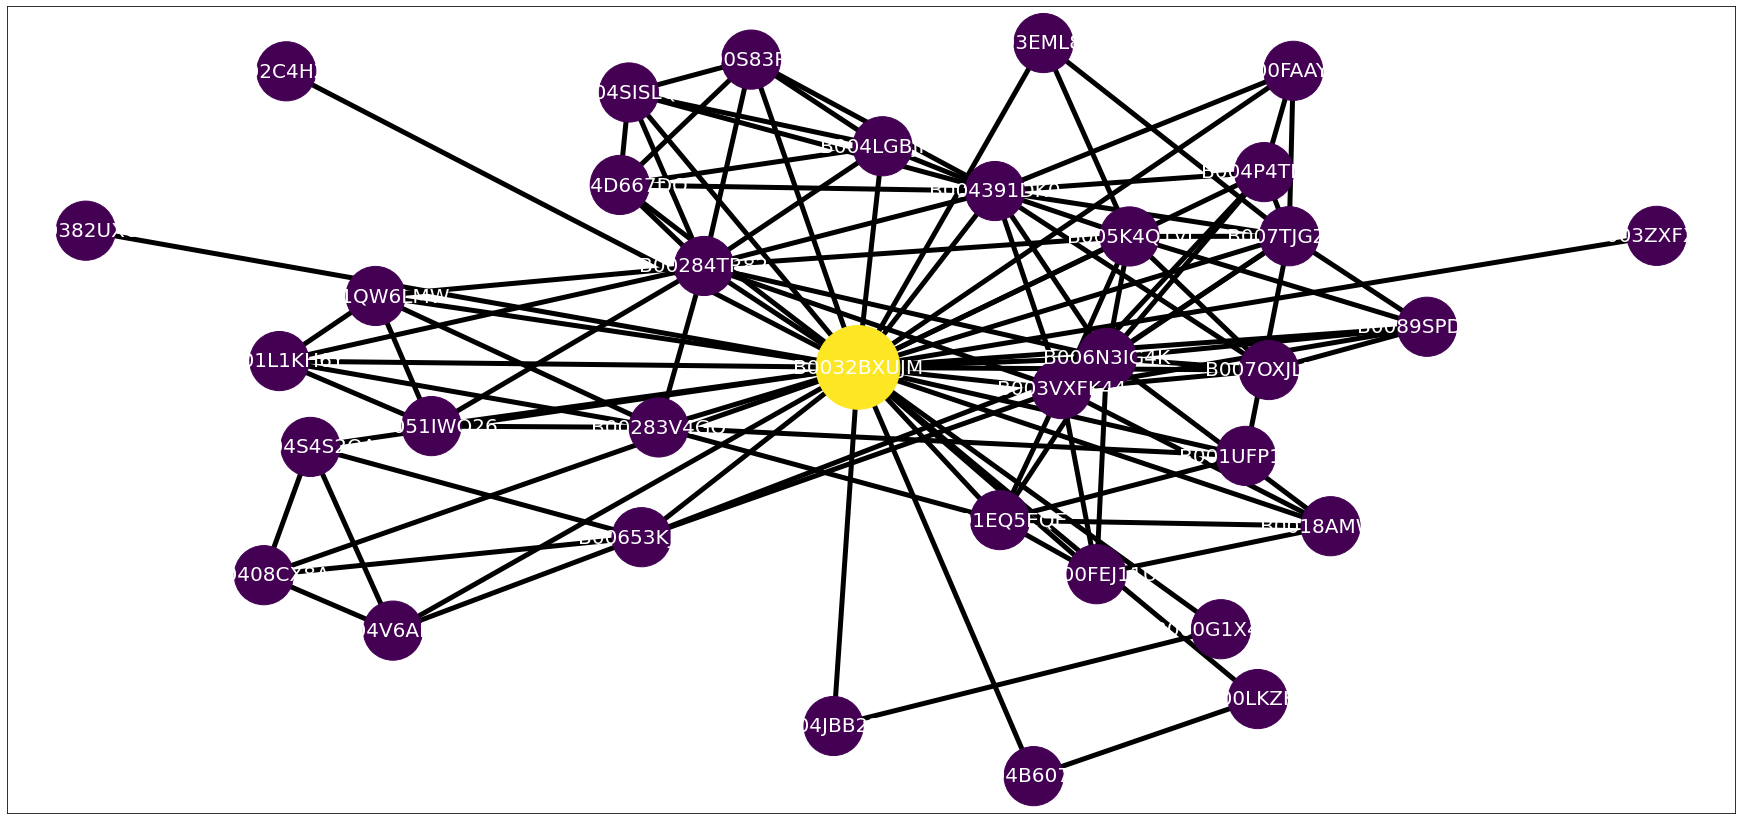

In [67]:
drawnodegraph(G_search,"B0032BXUJM")

In [68]:
#Checking for U_top_trim
get_centrality(U_top_trim)

Node              Degree    Betweeness    Closeness
--------------  --------  ------------  -----------
AQQLWCMRNDFGI   0.16616     0.130424       0.264959
A1YCWZWOXLUAY5  0.16533     0.0900606      0.269143
A2TJG4N8LNJW23  0.147913    0.0322978      0.25458
A1URVJ70108OZG  0.139066    0.0719881      0.260206
A1YJMG0QJXZLD4  0.131877    0.0752861      0.249293
AQLL2R1PPR46X   0.12386     0.0384         0.261771
A3OXHLG6DIBRW8  0.11916     0.0555729      0.259541
A2UQIQUOAB47OT  0.105889    0.00614895     0.247647
APP5MBH2BSX6I   0.105889    0.00614895     0.247647
A1S27P7KJO9I96  0.105889    0.00614895     0.247647


In [69]:
#Checking for U_bottom_trim
get_centrality(U_bottom_trim)

Node              Degree    Betweeness    Closeness
--------------  --------  ------------  -----------
AGFV9F4CI93S3   0.151293     0.0945789     0.227646
A25UTJ1AXFC0Z9  0.138367     0.0402159     0.246921
A1BJHZE41QWBX6  0.134841     0.0958875     0.247016
A2VBTN6ZR67YOF  0.127791     0.0468758     0.240345
A17TASZJT6Y39D  0.115159     0.0375793     0.23305
A31RULW0KNYJ5H  0.112515     0.0285597     0.23286
A3M1PLEYNDEYO8  0.112515     0.0285597     0.23286
AQ80LJNDLVZPG   0.110165     0.0246368     0.225076
AJXVOY9PS5UUP   0.10517      0.015849      0.238761
A3Q307658TBYCR  0.104583     0.0197753     0.224487


## Conclusion

---

<b>Citation: </b> 

* Study a certain node in the graph; taken from https://towardsdatascience.com/networkx-code-demo-for-manipulating-subgraphs-e45320581d13



---

<b>Additional Resources: </b> 

* For this exercise we are pulling product amazon.com product review data from https://snap.stanford.edu/data/web-Amazon.html